In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tc_study.experiment.synthetic_unsupervised_evaluation import generate_cov_mat, discrete_averaged_mi, discretize
from disentanglement_lib.evaluation.metrics import unsupervised_metrics as dlib_unsupervised_metrics
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

In [39]:
random_state = np.random.RandomState(42)
factors = 10
active_vars = 2
cov_min=0.002
cov_max=0.002
noise_strength=0.02
pv_var=0.02
n=10000
mean_mixed_vars = [-1, 1, 2]
mixed_vars = len(mean_mixed_vars)
truncation_point = mixed_vars+active_vars
bins=20

In [3]:
cov_m, _ = generate_cov_mat(factors, (active_vars + mixed_vars), cov_min, cov_max, random_state, pv_var)

In [4]:
mu = np.repeat(0, factors)

In [5]:
mean = random_state.multivariate_normal(mu, cov_m, n).T
sigma = np.diag([noise_strength if i < (active_vars + mixed_vars) else 1 for i in range(factors)])
eps = random_state.multivariate_normal(mu, np.identity(factors), n)
sampled = mean + np.dot(eps, sigma).T
for i in range(mixed_vars):
    if i == 0:
        # Change mean of active var subpart
        mean[i, :n//2] += mean_mixed_vars[i]
        sampled[i, :n//2] += mean_mixed_vars[i]
        # Replace other half with passive variable like distribution
        mean[i, n//2:] = random_state.normal(0, pv_var, n//2)
        sampled[i, n//2:] = mean[i, n//2:] + eps.T[i, n//2:]
    else:
        # Change mean of active var subpart
        mean[i, n//2:] += mean_mixed_vars[i]
        sampled[i, n//2:] += mean_mixed_vars[i]
        # Replace other half with passive variable like distribution
        mean[i, :n//2] = random_state.normal(0, pv_var, n//2)
        sampled[i, :n//2] = mean[i, :n//2] + eps.T[i, :n//2]

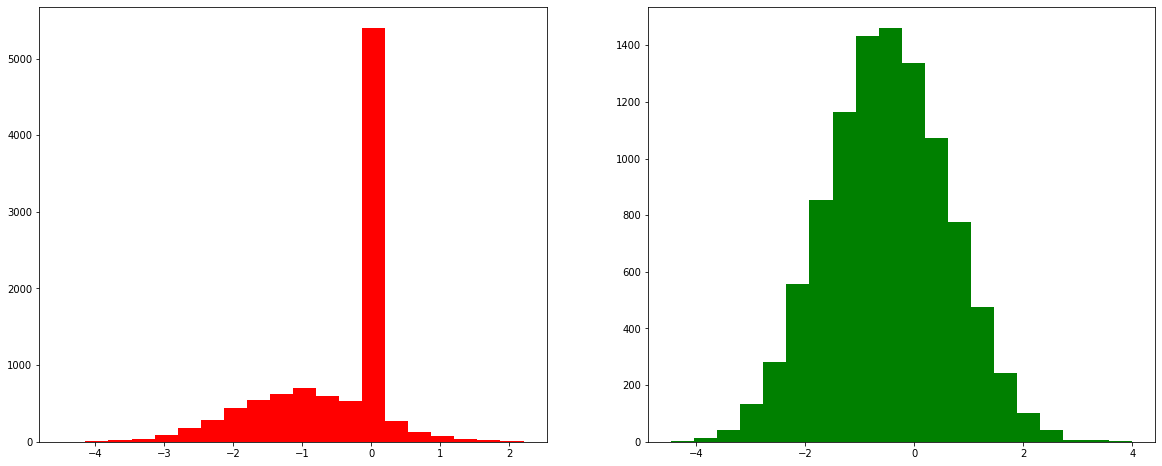

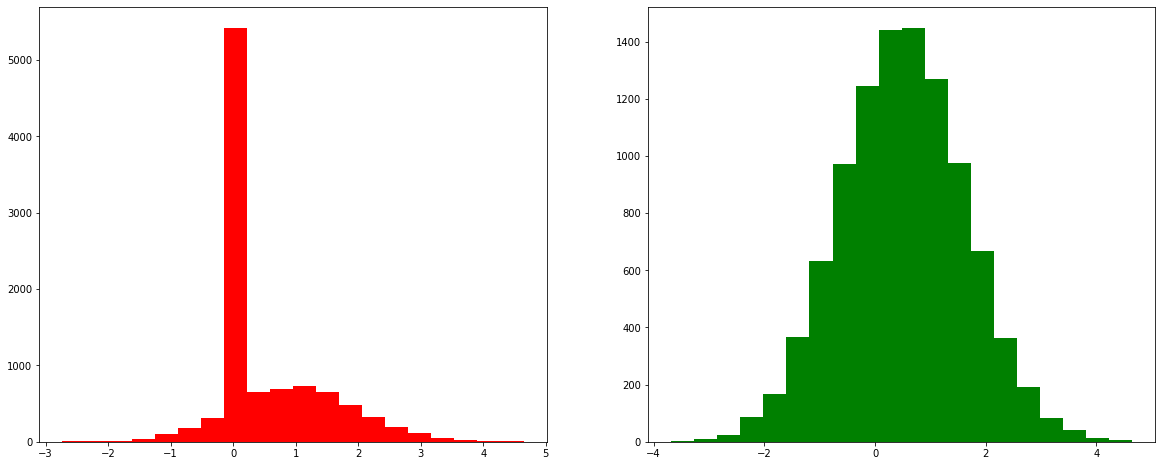

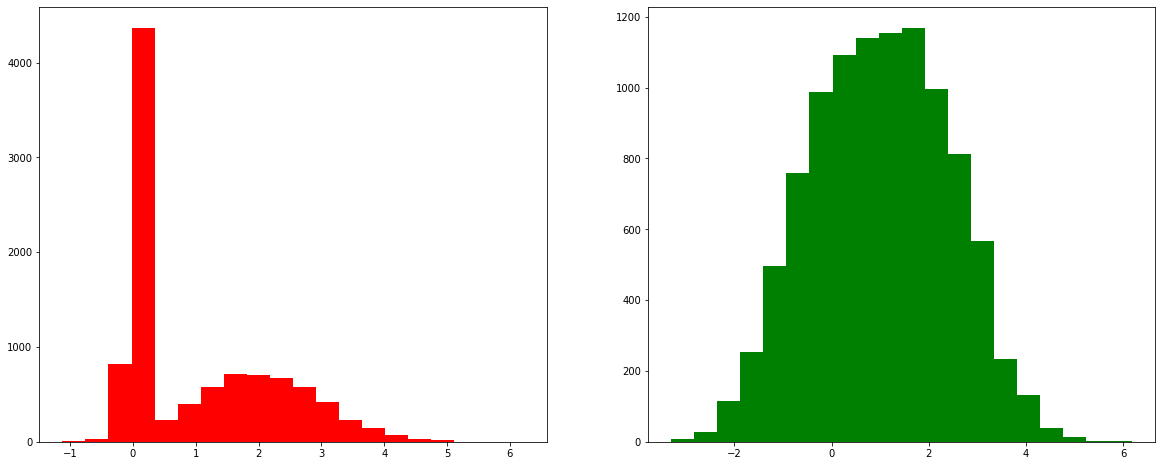

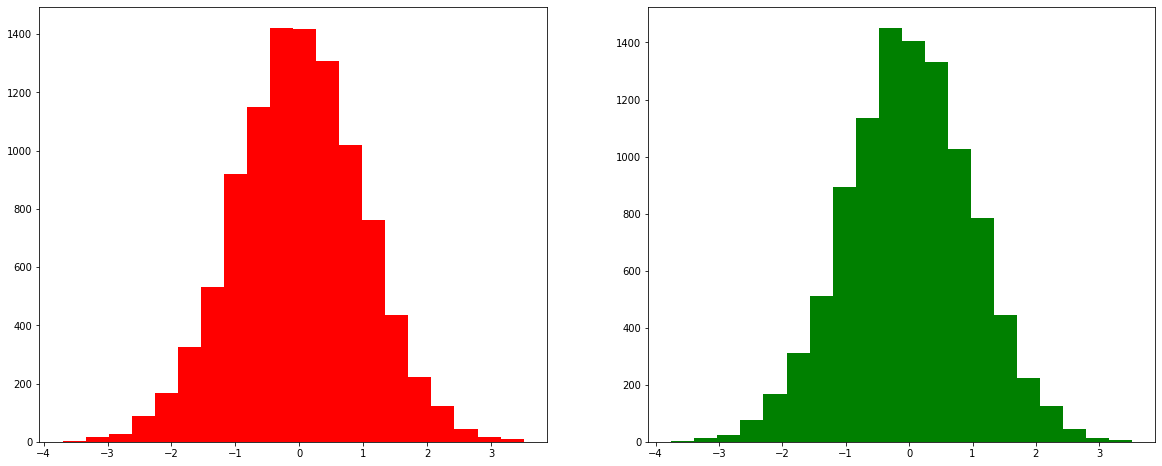

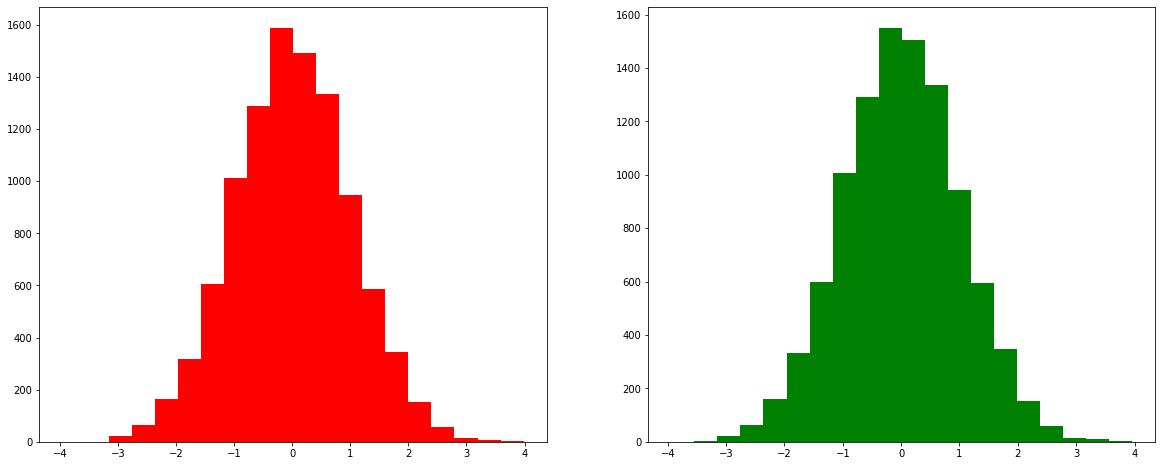

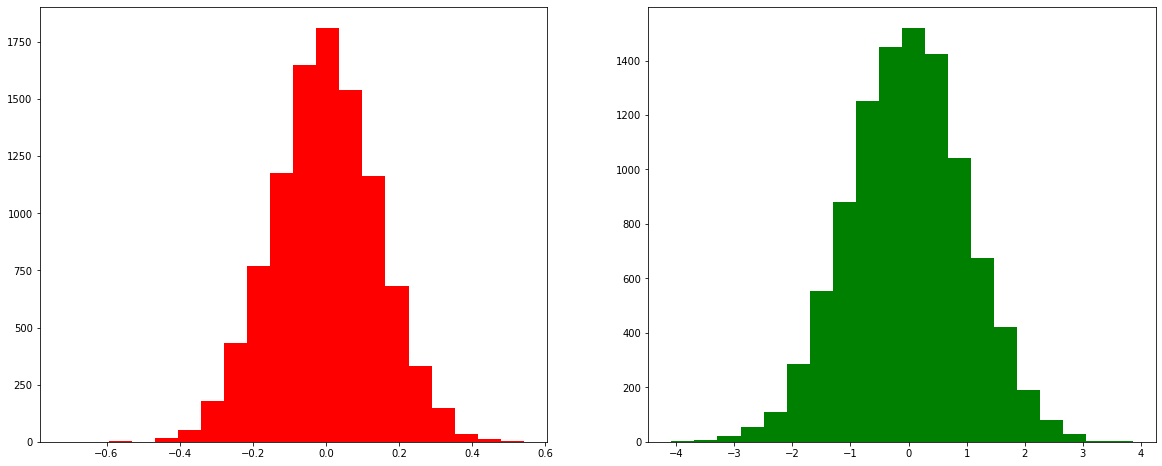

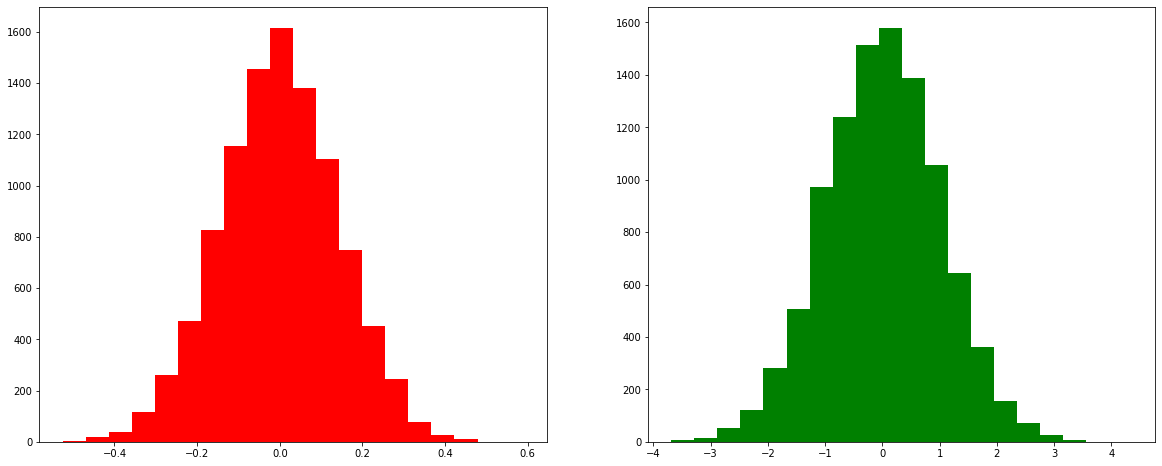

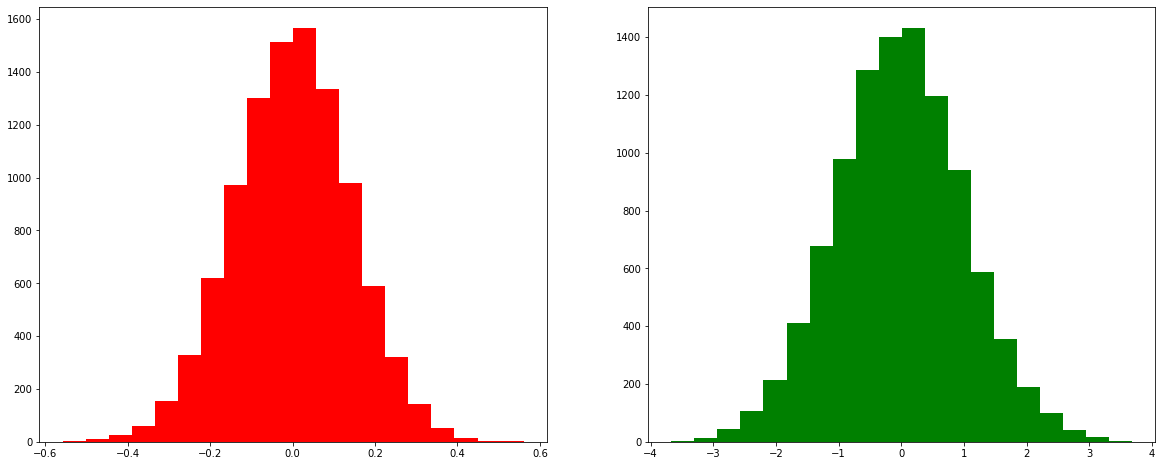

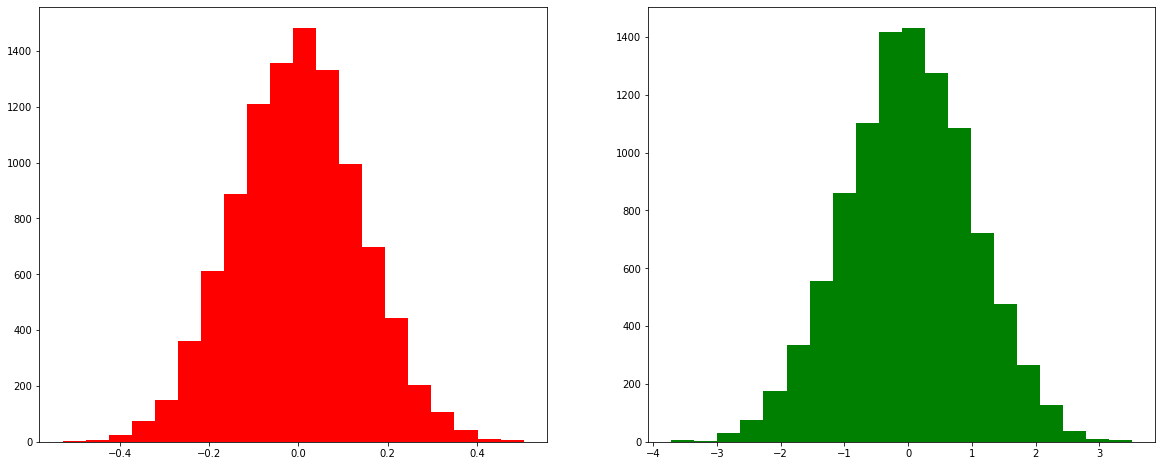

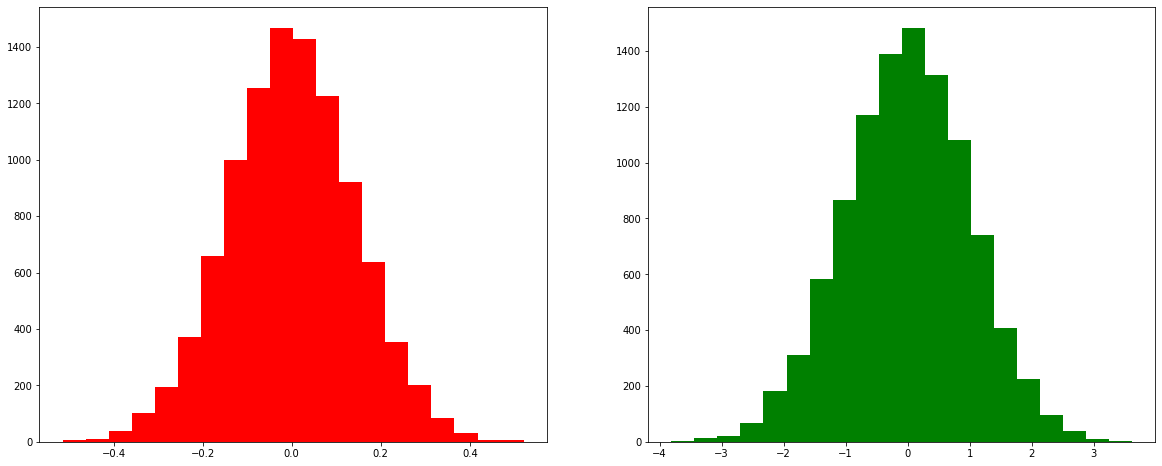

In [6]:
for i in range(factors):
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    ax[0].hist(mean[i], bins=bins, color = 'r')
    ax[1].hist(sampled[i], bins=bins, color = 'g')
    plt.show()

In [7]:
cov_m  = np.cov(mean)
cov_mt = cov_m[:truncation_point, :truncation_point]
cov_mt = np.cov(mean[:truncation_point])
cov_s = np.cov(sampled)
cov_st = cov_s[:truncation_point, :truncation_point]

In [8]:
cov_mt

array([[ 7.29662294e-01,  2.51104558e-01,  5.02880759e-01,
         7.93602144e-03,  1.05911781e-02],
       [ 2.51104558e-01,  7.64824986e-01,  5.17885049e-01,
         1.39947189e-03, -4.61735771e-03],
       [ 5.02880759e-01,  5.17885049e-01,  1.49762597e+00,
        -4.42475929e-03,  3.69758849e-03],
       [ 7.93602144e-03,  1.39947189e-03, -4.42475929e-03,
         9.95098951e-01, -9.55429889e-03],
       [ 1.05911781e-02, -4.61735771e-03,  3.69758849e-03,
        -9.55429889e-03,  1.00712915e+00]])

In [9]:
cov_st

array([[ 1.25098845e+00,  2.61214000e-01,  5.03763369e-01,
         1.19942322e-02,  9.34421267e-03],
       [ 2.61214000e-01,  1.26088387e+00,  5.22571948e-01,
         8.09593899e-03, -3.61707284e-03],
       [ 5.03763369e-01,  5.22571948e-01,  1.99936921e+00,
        -1.50483033e-03,  9.45700891e-03],
       [ 1.19942322e-02,  8.09593899e-03, -1.50483033e-03,
         9.96216396e-01, -9.81135478e-03],
       [ 9.34421267e-03, -3.61707284e-03,  9.45700891e-03,
        -9.81135478e-03,  1.00686319e+00]])

In [62]:
mean_d = discretize(mean, num_bins=bins)
mean_dt = discretize(mean[:truncation_point], num_bins=bins)
sampled_d = discretize(sampled, num_bins=bins)
sampled_dt = discretize(sampled[:truncation_point], num_bins=bins)

In [63]:
tc_m, tc_s = dlib_unsupervised_metrics.gaussian_total_correlation(cov_m), dlib_unsupervised_metrics.gaussian_total_correlation(cov_s)
tc_mt, tc_st = dlib_unsupervised_metrics.gaussian_total_correlation(cov_mt), dlib_unsupervised_metrics.gaussian_total_correlation(cov_st)

In [64]:
mi_m, mi_s = discrete_averaged_mi(mean_d), discrete_averaged_mi(sampled_d)
mi_mt, mi_st = discrete_averaged_mi(mean_dt), discrete_averaged_mi(sampled_dt)

In [65]:
scores_str = "{:<20} {:<15f} {:<15f}\n"
msg = "{:<20} {:<15} {:<15}\n".format("Representation", "Mean", "Sampled")
msg += "{:=^50}\n".format("")
msg += scores_str.format("TC Full", tc_m, tc_s)
msg += scores_str.format("   Truncated", tc_mt, tc_st)
msg += "{:-^50}\n".format("")
msg += scores_str.format("MI Full", mi_m, mi_s)
msg += scores_str.format("   Truncated", mi_mt, mi_st)
print(msg)

Representation       Mean            Sampled        
TC Full              1.102230        0.120723       
   Truncated         0.274412        0.117709       
--------------------------------------------------
MI Full              0.076877        0.018651       
   Truncated         0.156664        0.029969       



In [66]:
def draw_heatmaps(cm_mean, cm_sampled, scores):  
    mi_mean, mi_sampled = list(scores.values())[0]

    fig, axs = plt.subplots(ncols=2, figsize=(20,8), gridspec_kw=dict(width_ratios=[8,8]))
    fig.suptitle(list(scores.keys())[0], fontsize=20)

    sns.heatmap(cm_mean, ax=axs[0])
    sns.heatmap(cm_sampled, yticklabels=False, ax=axs[1])
    
    axs[0].set_title("Mean = {:f}".format(mi_mean), fontsize=18)
    axs[1].set_title("Sampled = {:f}".format(mi_sampled), fontsize=18)

[  4   7   8  40  96 180 313 829 650 695 726 653 479 324 193 113  51  28
  10   4]


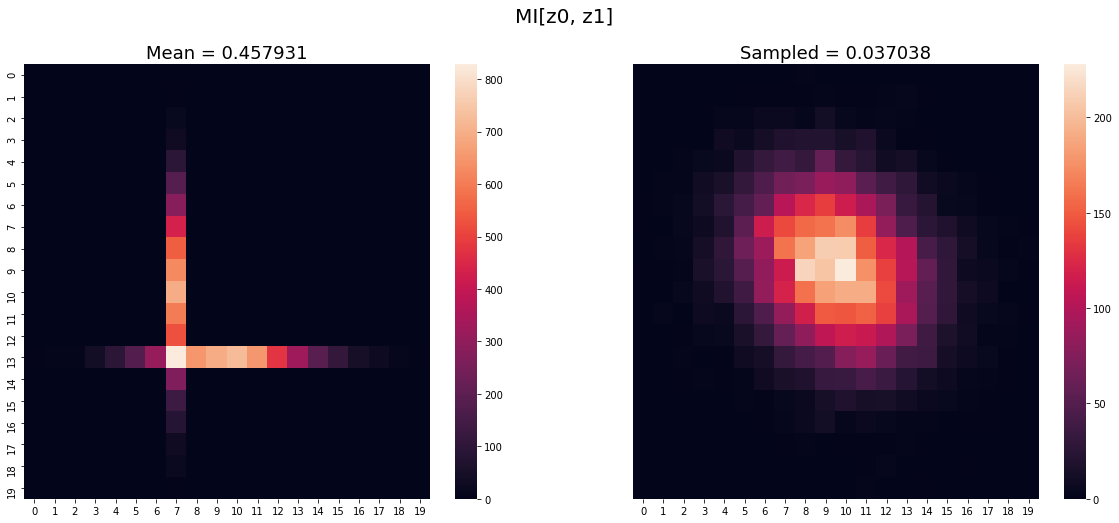

[ 10  31 136 457 233 401 576 712 700 673 576 421 225 141  68  25  14   2
   1   1]


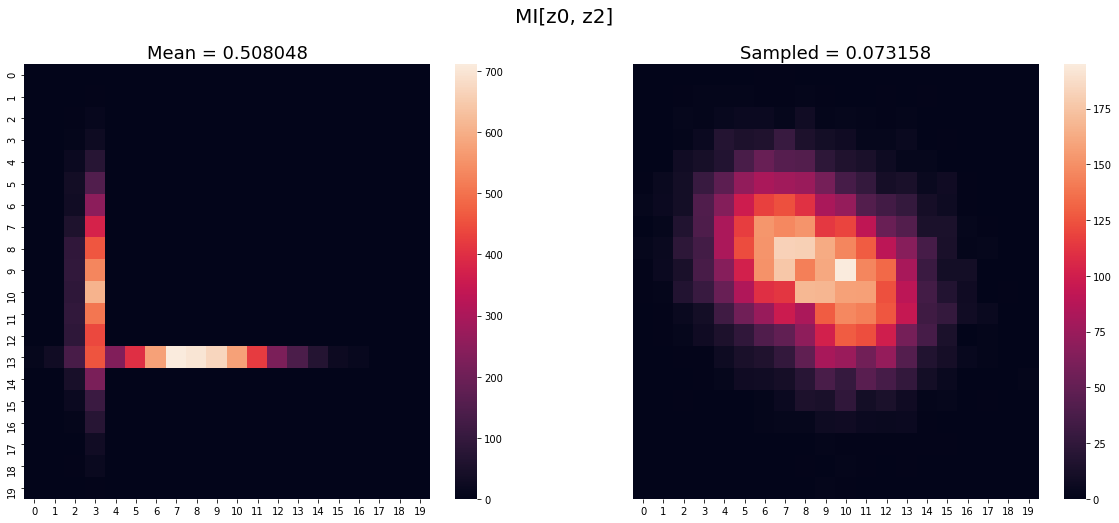

[  1   9  17  44  92 170 303 502 586 785 726 718 551 415 243 124  70  29
  12   6]


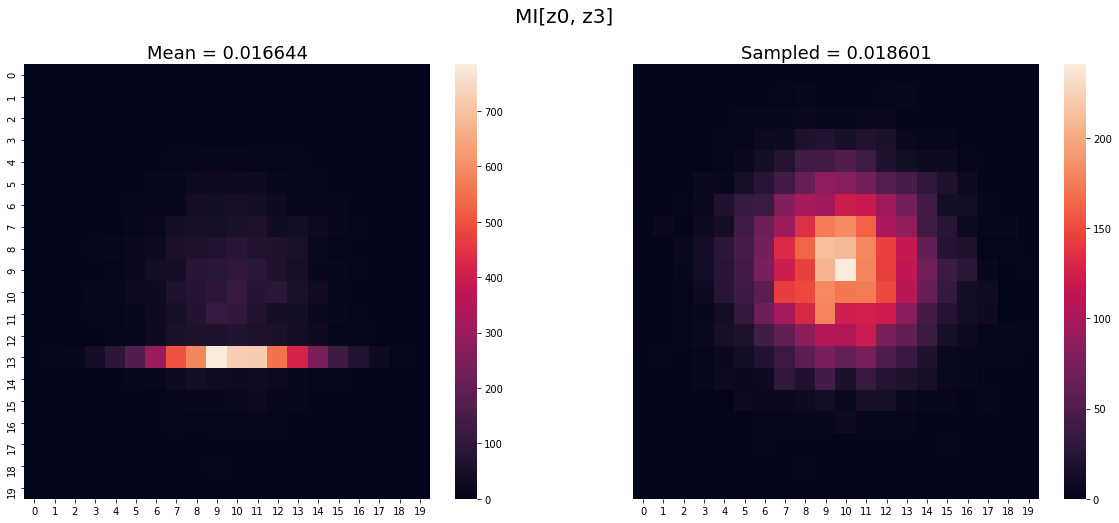

[  0   0  14  35  75 181 328 526 699 858 832 749 480 317 182  83  30   8
   5   1]


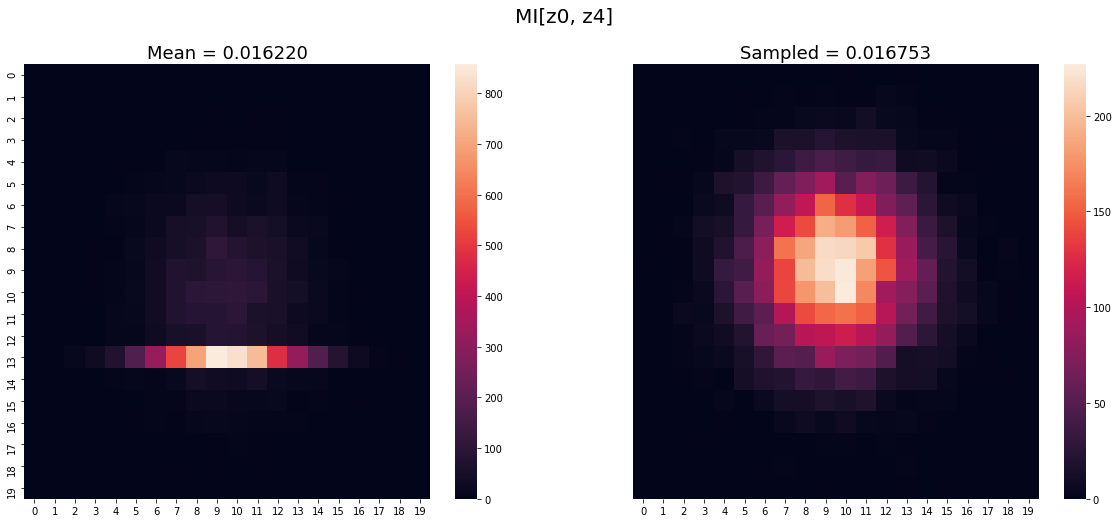

[  1   0   9  25  96 239 410 596 908 984 837 638 356 190  85  19   6   4]


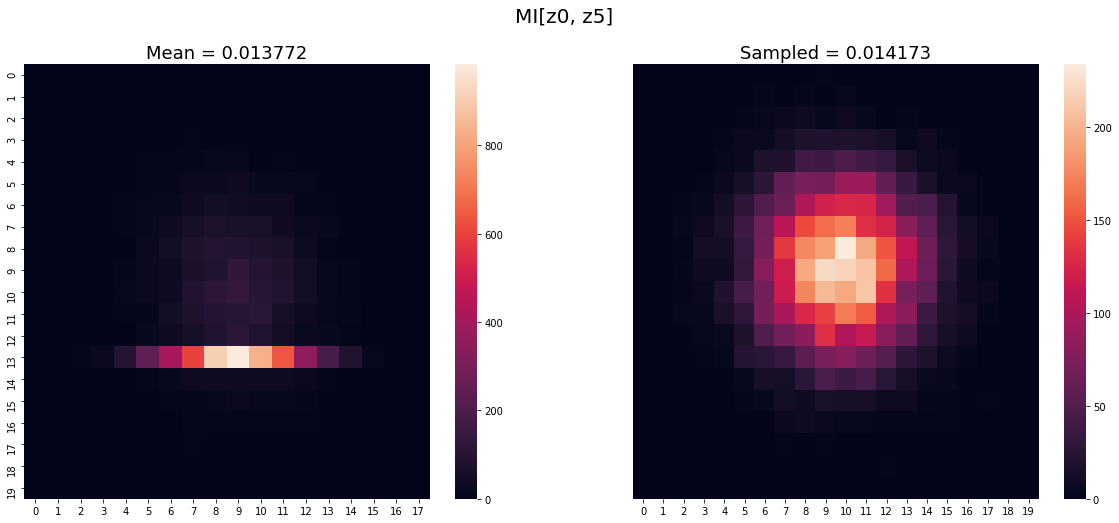

[  2  11  22  57 128 257 435 595 790 831 781 626 428 238 140  39  19   4
   0   0]


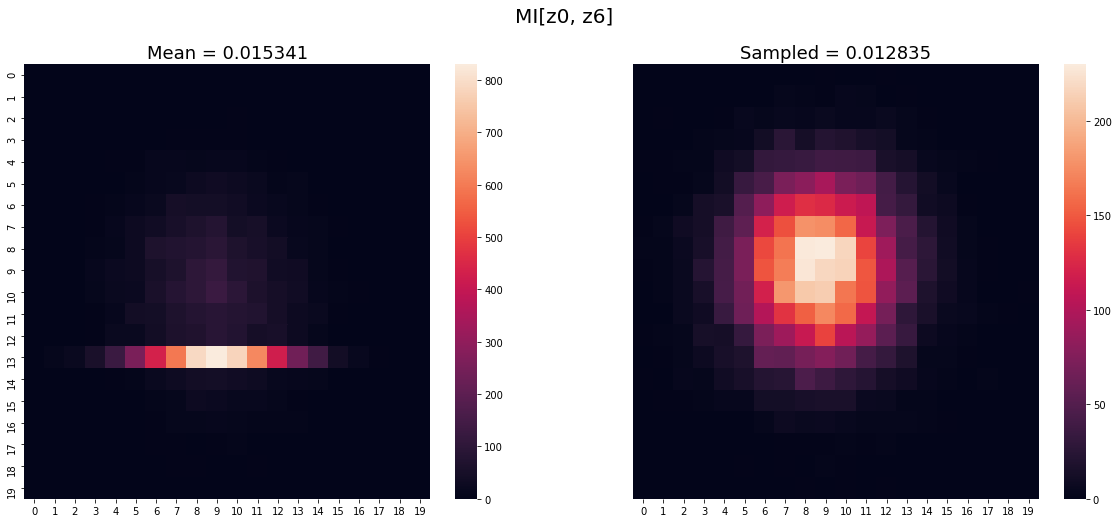

[  0   5  11  23  81 166 342 533 679 827 863 732 506 321 180  87  31  11
   3   2]


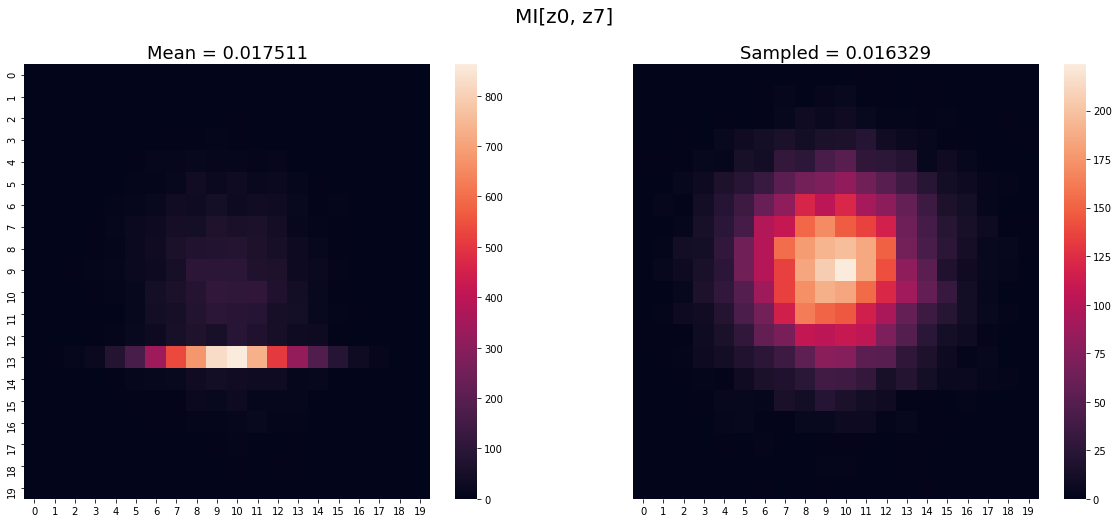

[  2   4  13  41  71 183 312 482 656 766 840 698 533 363 242 112  57  22
   2   4]


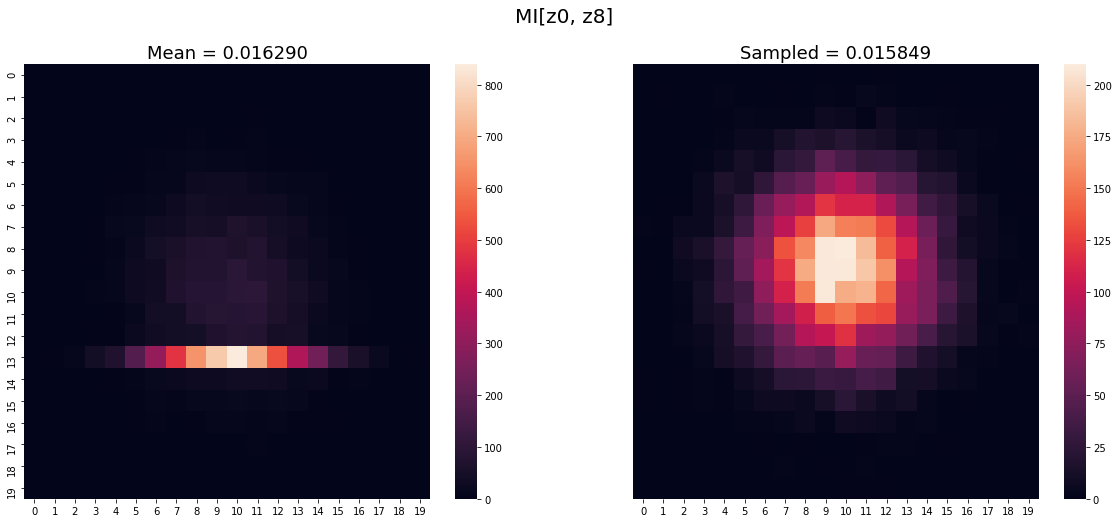

[  3   6  24  56 109 198 338 550 679 780 760 670 490 377 189 109  43  14
   4   4]


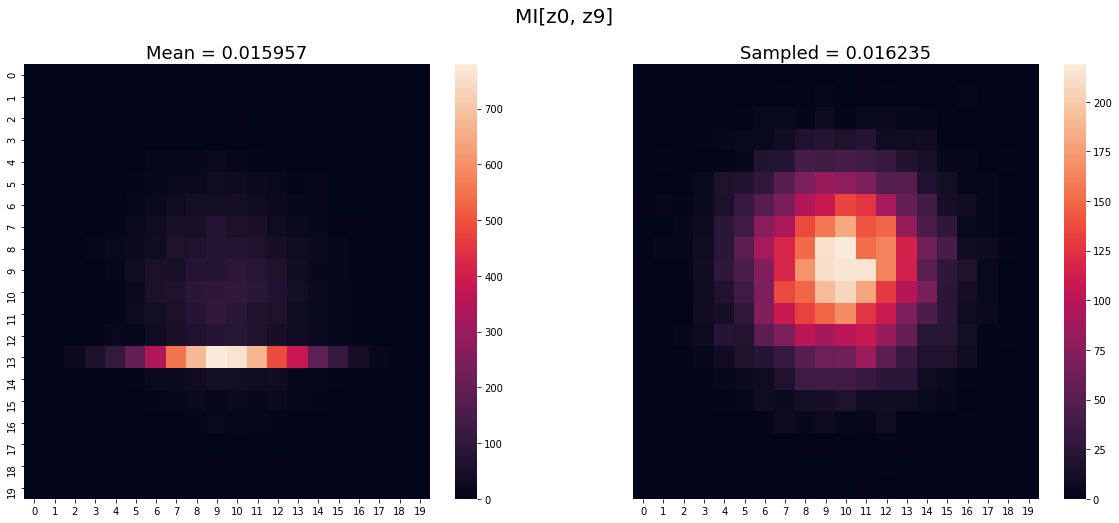

[ 0  1  5  7 16 22 42 34 47 47 38 26 19 12  3  1  3  0  0  1]


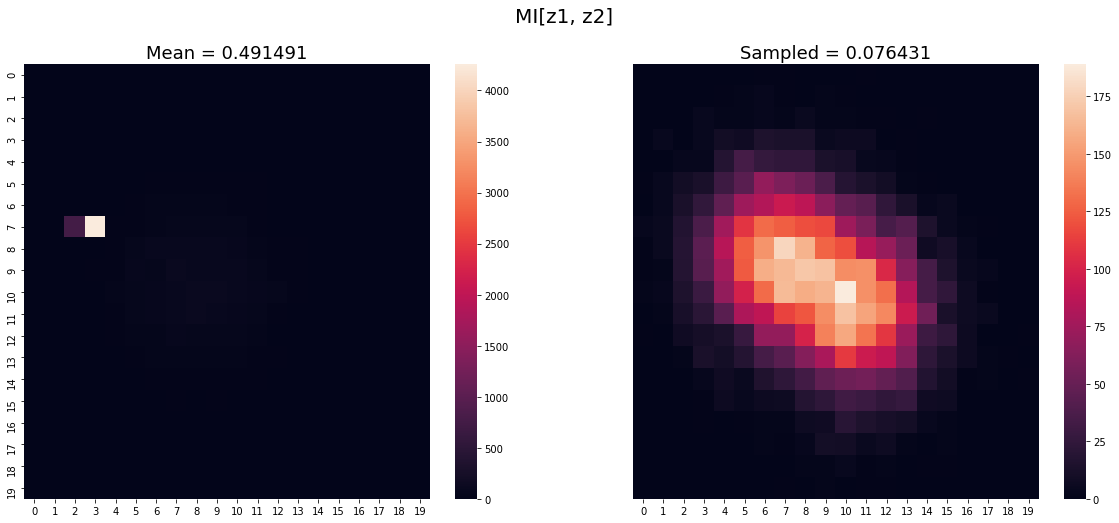

[ 0  1  0  0  4  8 16 28 35 48 39 49 36 32 13 10  3  0  1  1]


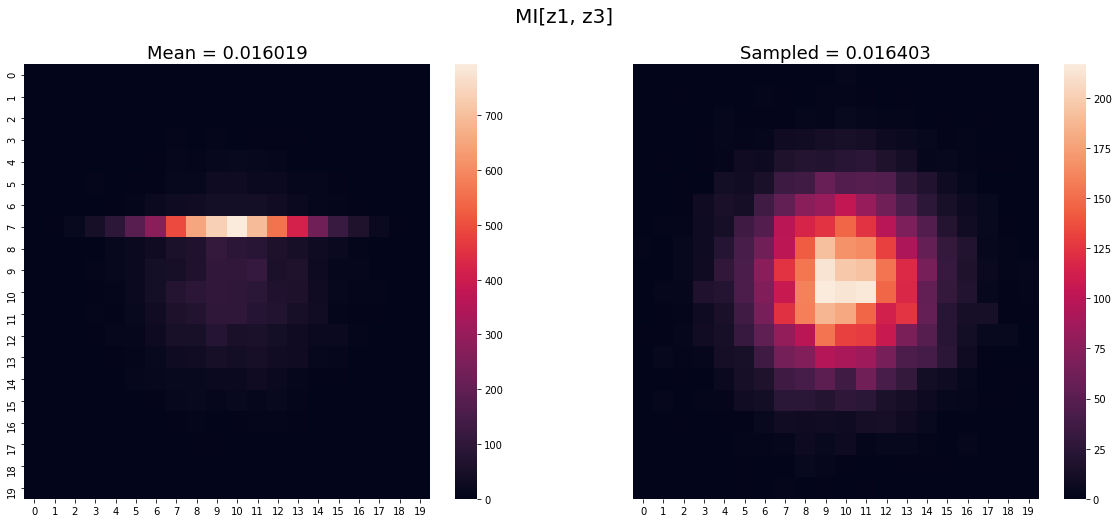

[ 0  0  3  4  3  5 26 33 40 52 48 50 27 16  8  6  2  1  0  0]


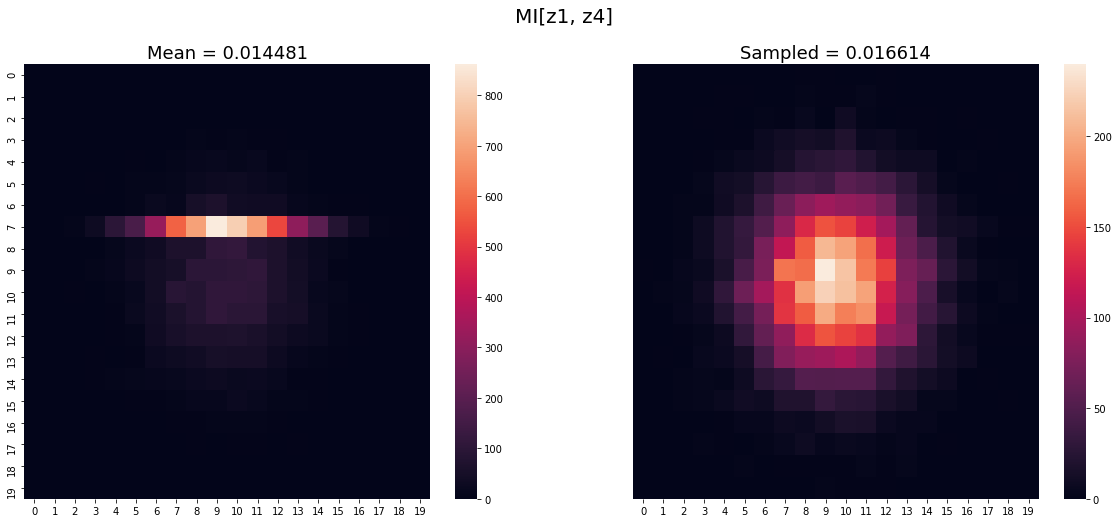

[ 0  0  0  0  5 10 24 33 57 68 45 34 24 21  2  1  0  0]


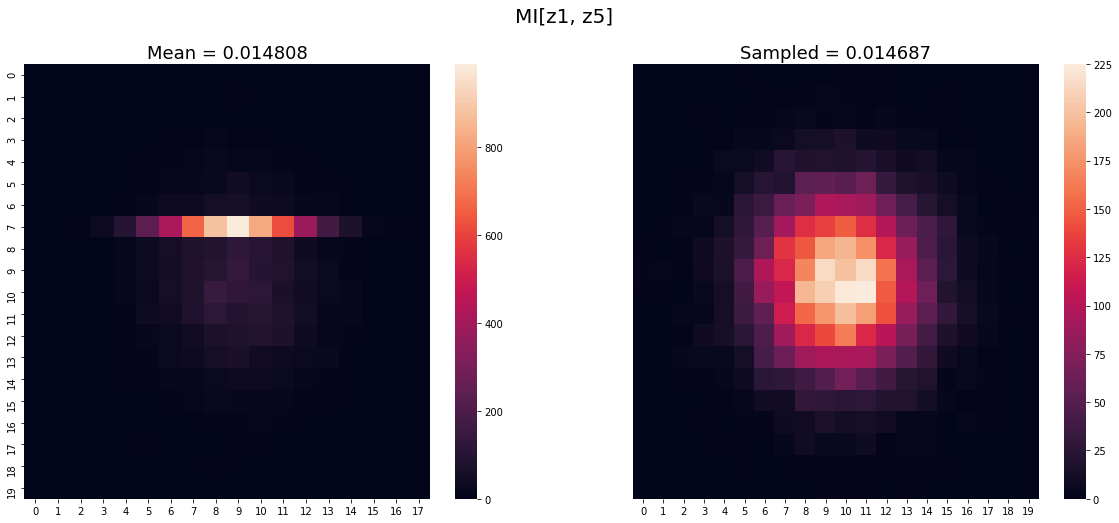

[ 0  0  2  1  8 21 19 30 49 45 50 30 34 19 11  4  1  0  0  0]


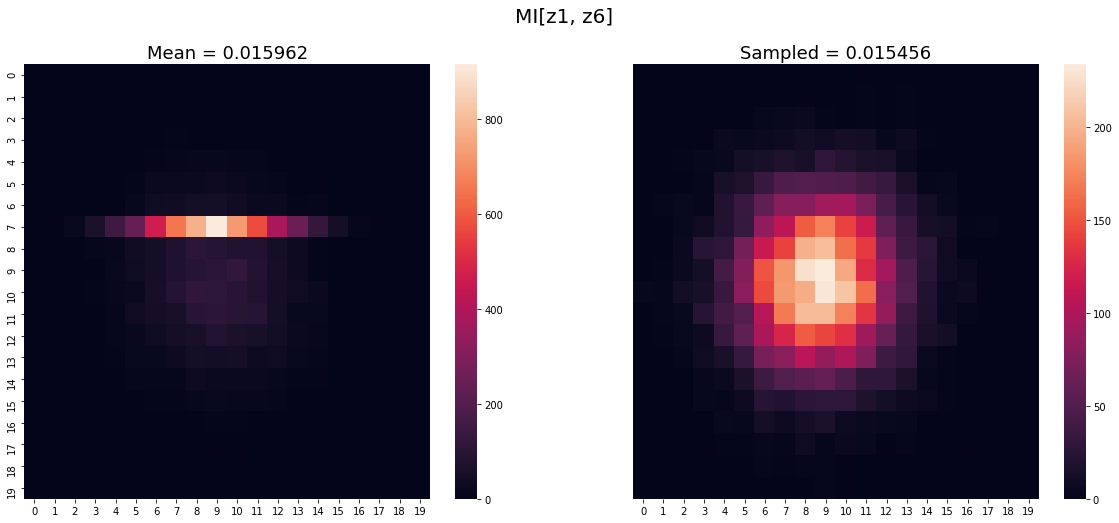

[ 0  0  0  1  4 12 14 26 46 51 55 47 26 20 15  5  2  0  0  0]


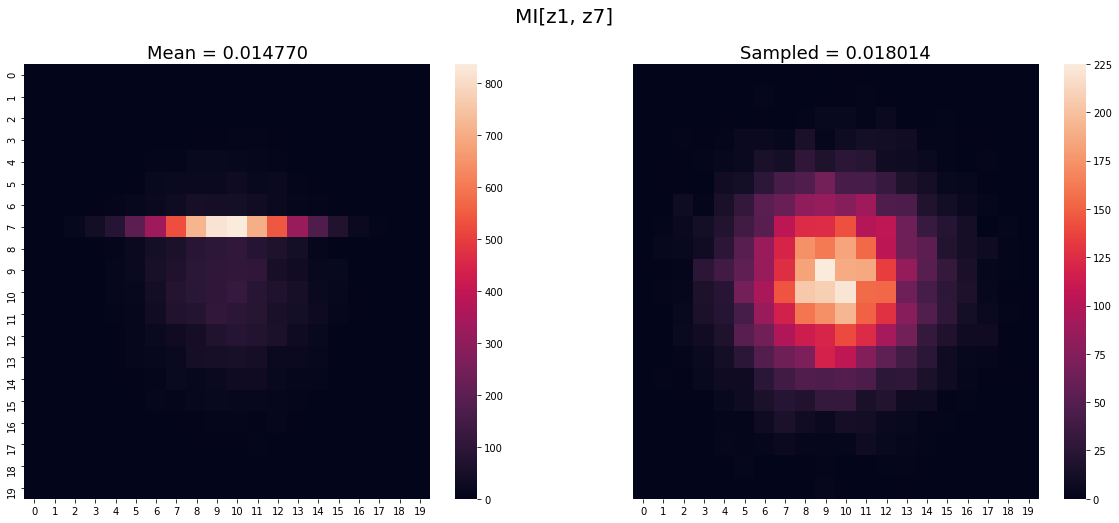

[ 0  0  0  1  5  6 20 33 42 36 50 47 30 29 12  9  1  3  0  0]


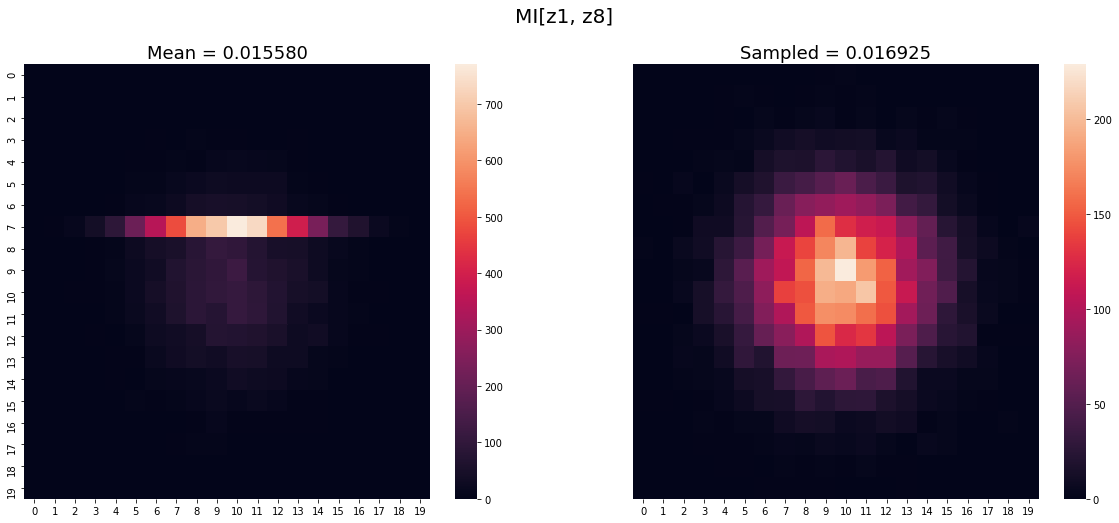

[ 0  1  3  0  4  8 15 30 42 39 48 46 29 27 11 13  5  2  1  0]


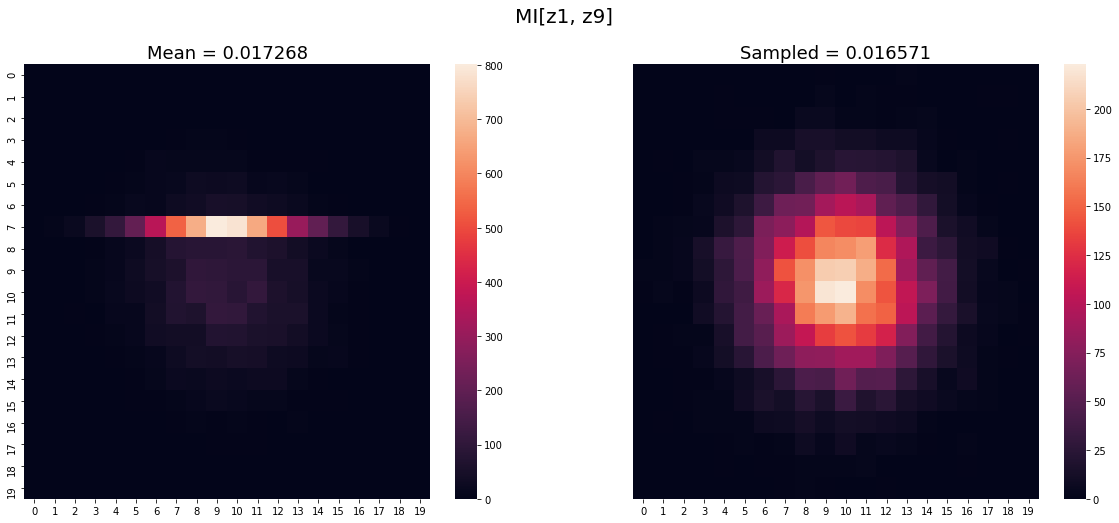

[ 0  1  1  2  3  9  7 11 21 18 18 17 11 10  6  6  0  0  0  0]


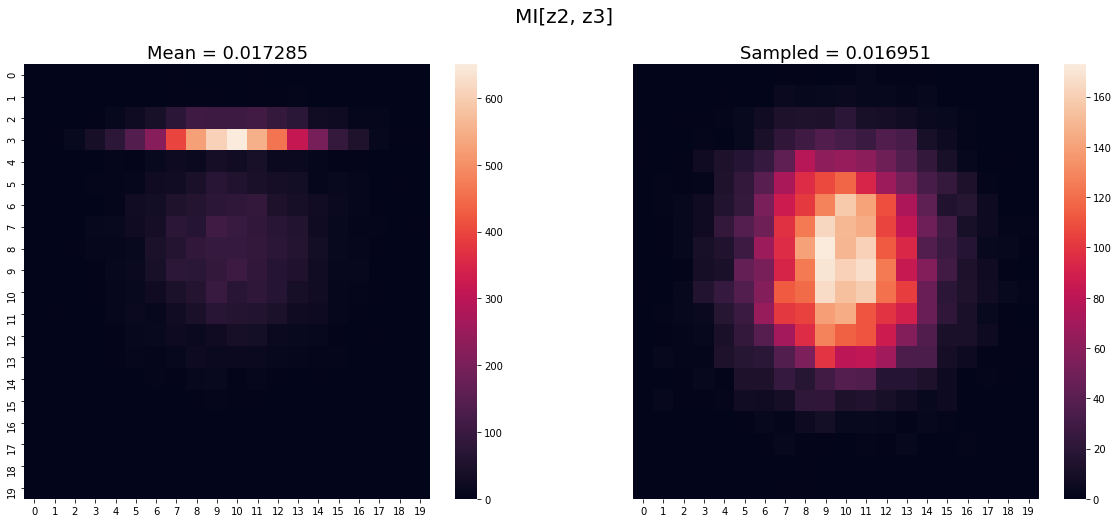

[ 0  0  0  1  0  5 13 13 16 32 18 20  9 12  1  0  1  0  0  0]


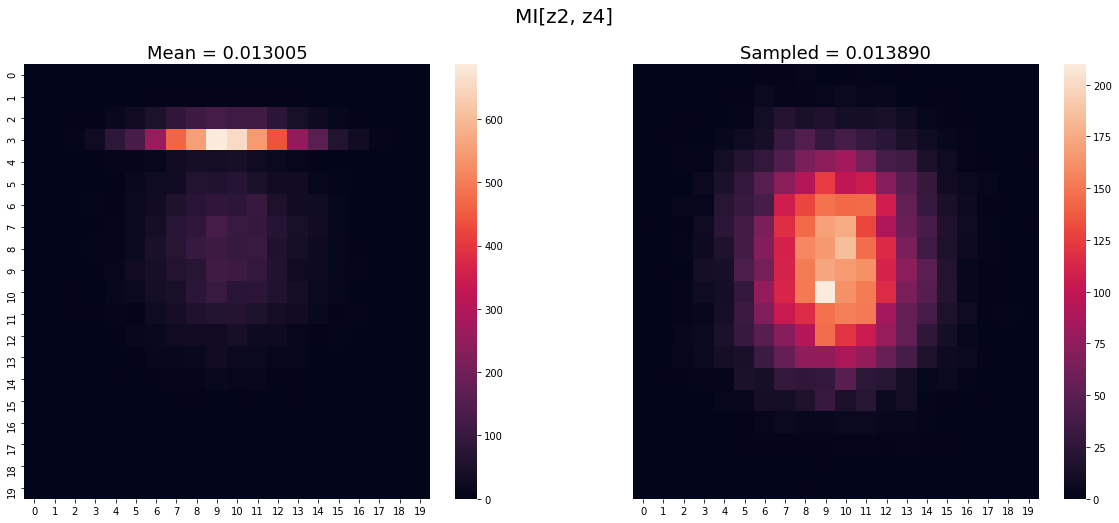

[ 0  0  0  0  4  2  6 12 26 29 29 19  7  6  1  0  0  0]


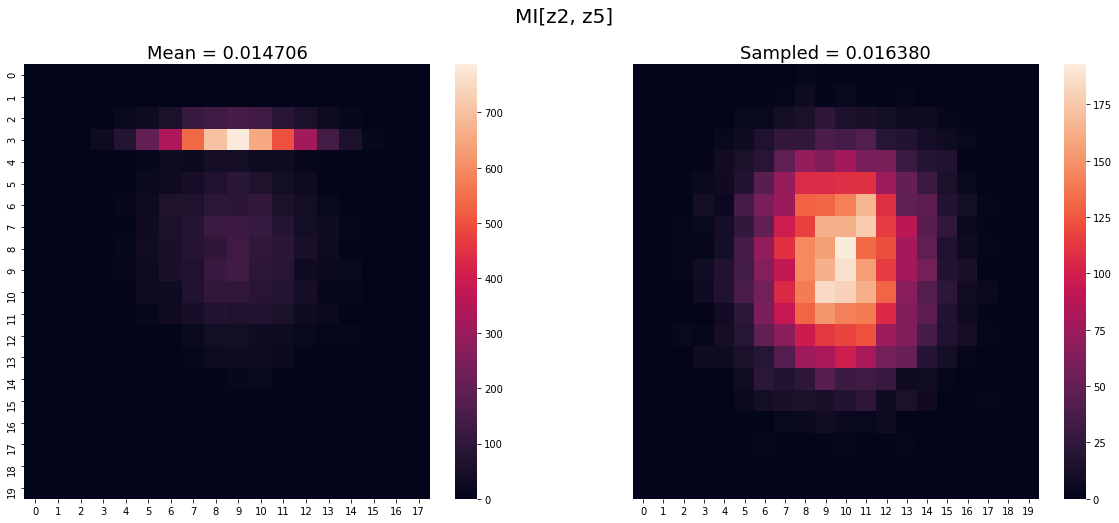

[ 0  0  1  0  4  8 10 16 13 26 16 16 17 11  2  1  0  0  0  0]


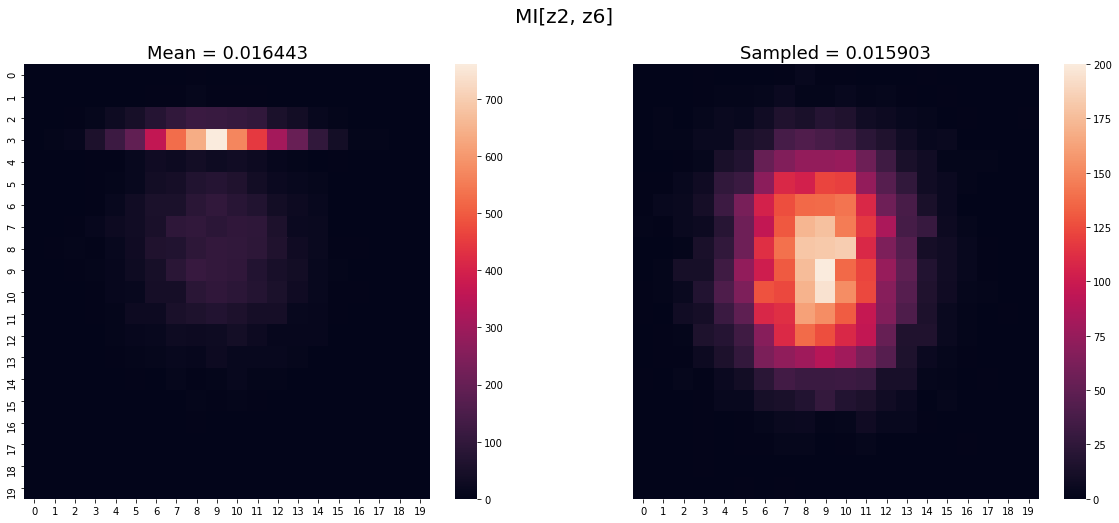

[ 0  0  0  0  2  4  7 18 17 26 19 18 17  9  2  2  0  0  0  0]


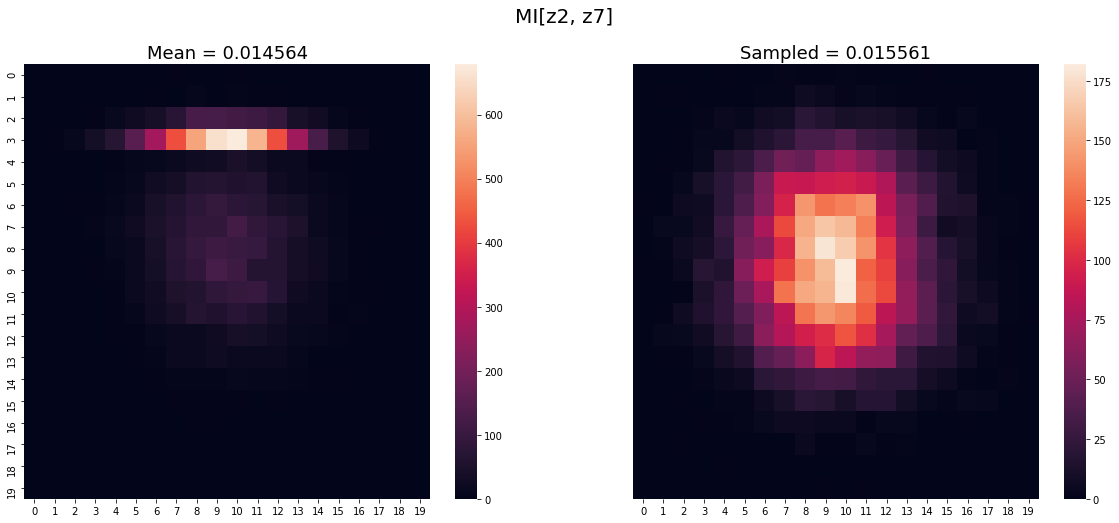

[ 0  0  0  1  0  5  9 13 20 19 20 16 17  9  5  2  4  1  0  0]


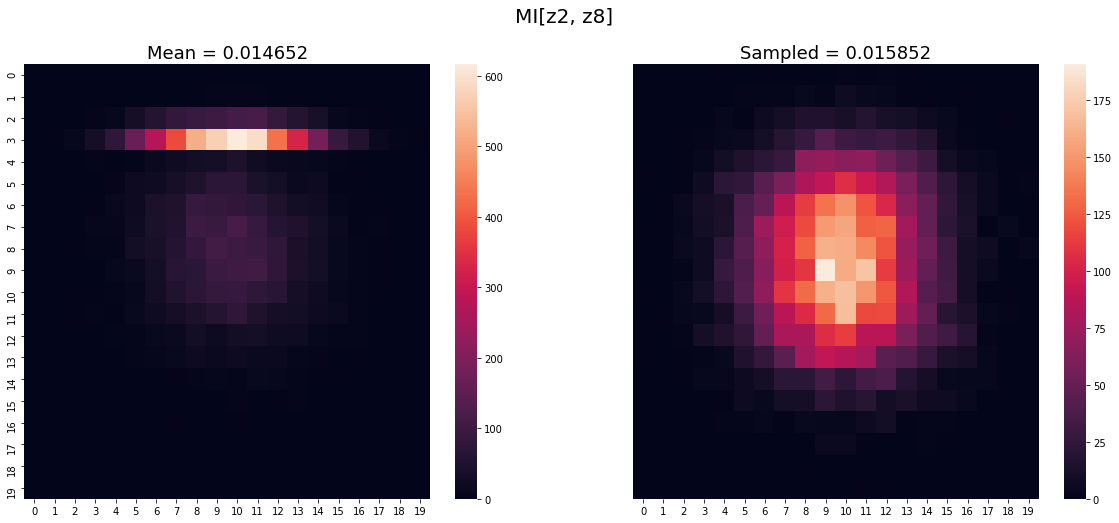

[ 0  0  0  2  3  2  7 13 22 19 13 19 18 13  4  5  0  0  0  1]


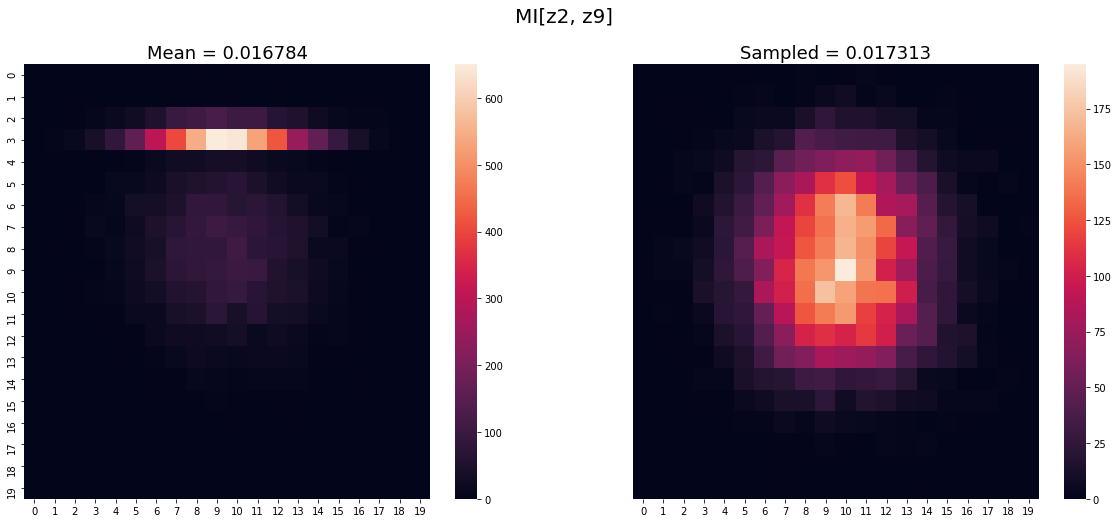

[  0   0   1   5   8  25  51  88 112 130  98  86  78  41  23   8   7   0
   1   0]


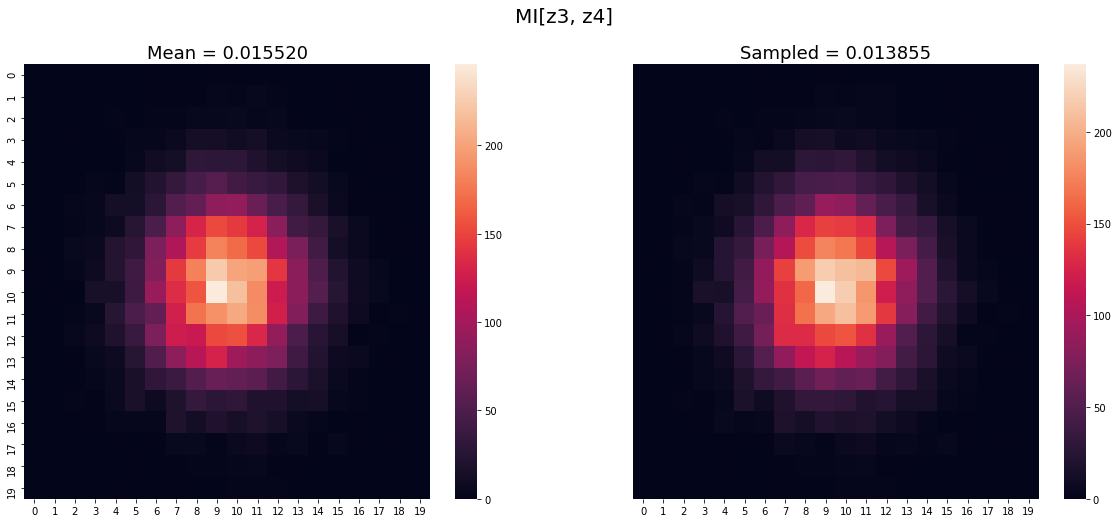

[  0   0   1   3   6  26  58  94 129 133 116 111  45  25  12   0   3   0]


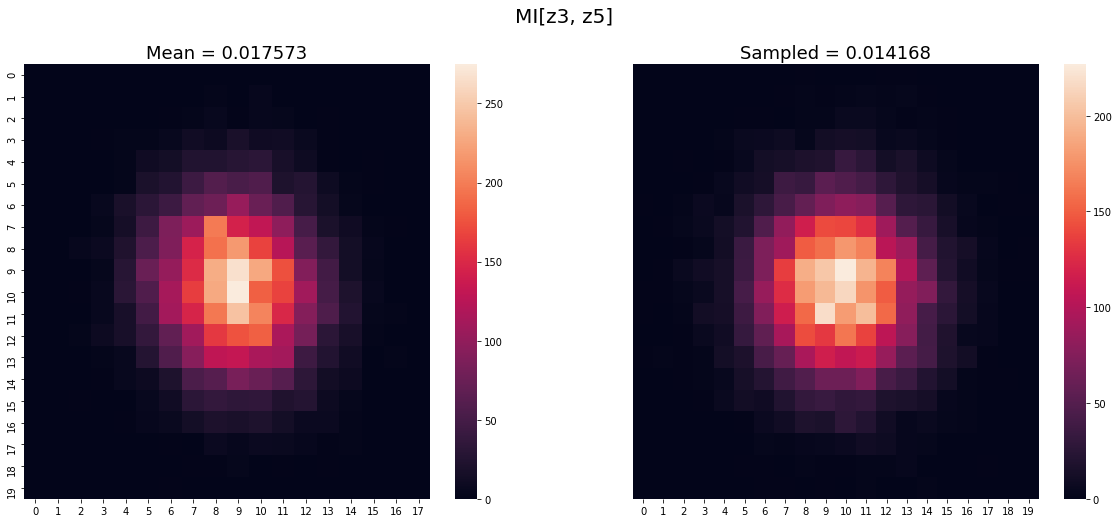

[  2   1   1   9  17  23  67  81 118 126  93 102  59  39  17   6   1   0
   0   0]


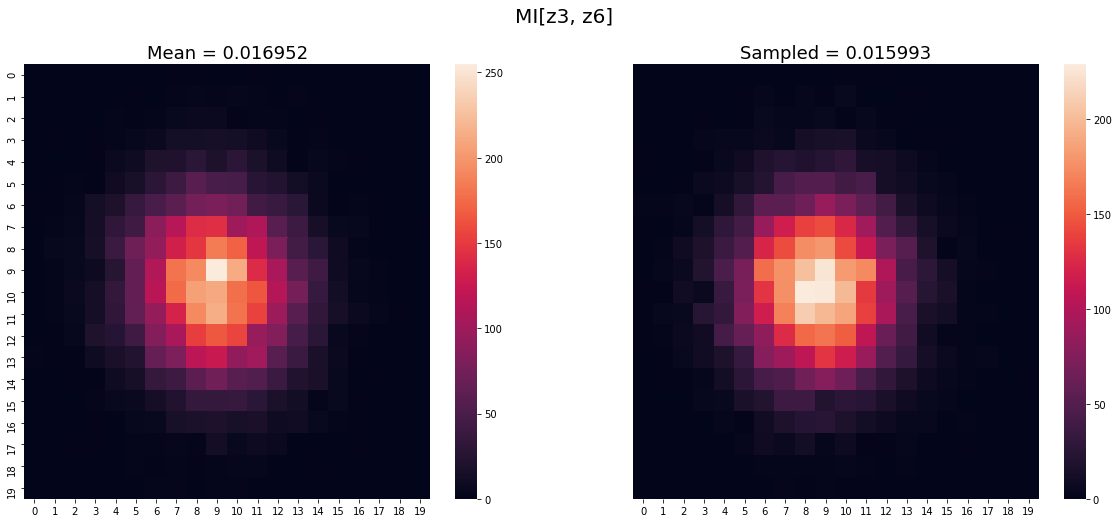

[  0   3   1   2  10  22  53  69  94 119 126  93  87  53  15  11   4   0
   0   0]


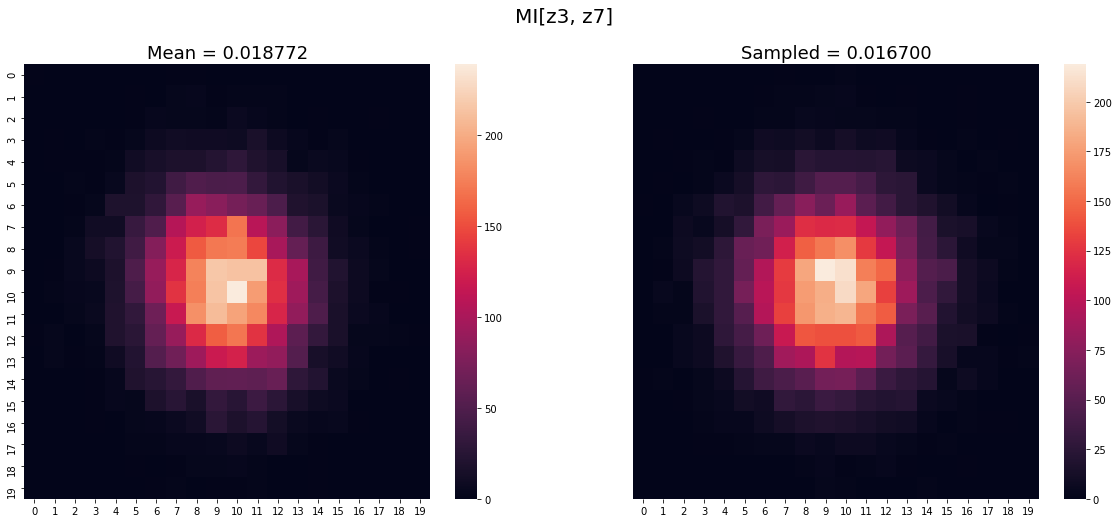

[  1   0   0   3  17  22  46  68  95  96 117 118  57  52  42  17   8   3
   0   0]


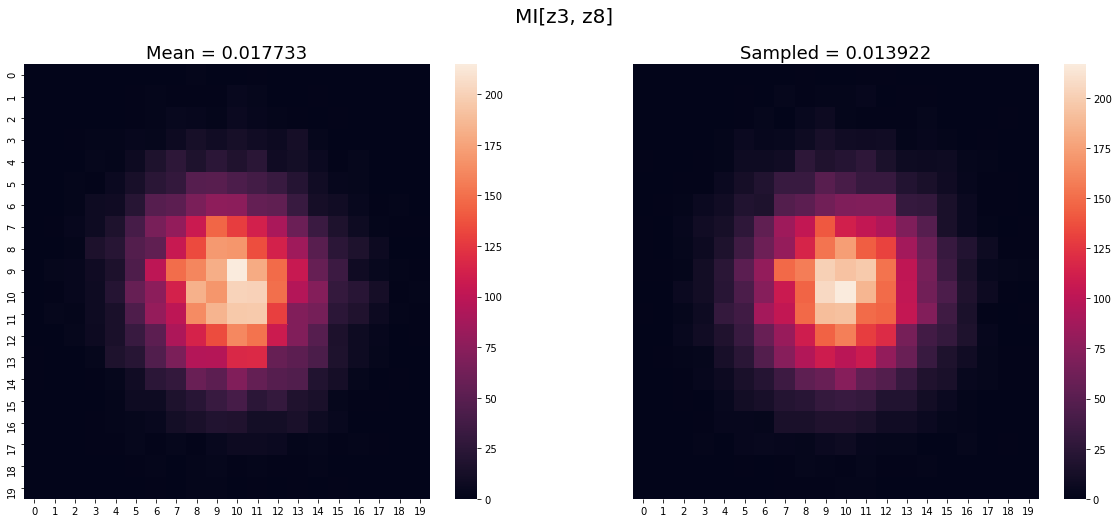

[  1   1   1  11  11  26  39  85  97 101  95 114  83  47  30  14   4   2
   0   0]


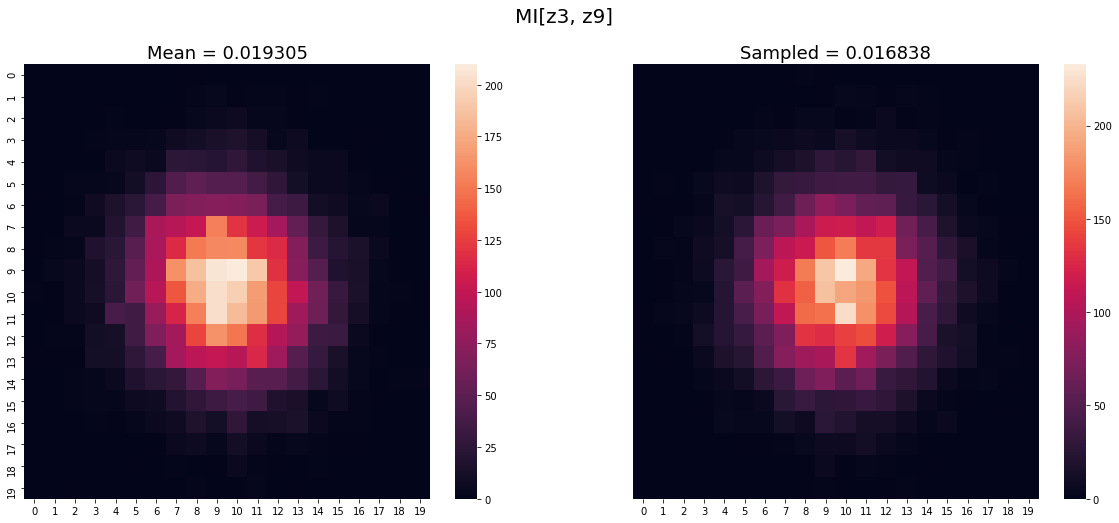

[  0   0   1   3   3  20  39  67  79 106  96  92  46  23   6   2   3   0]


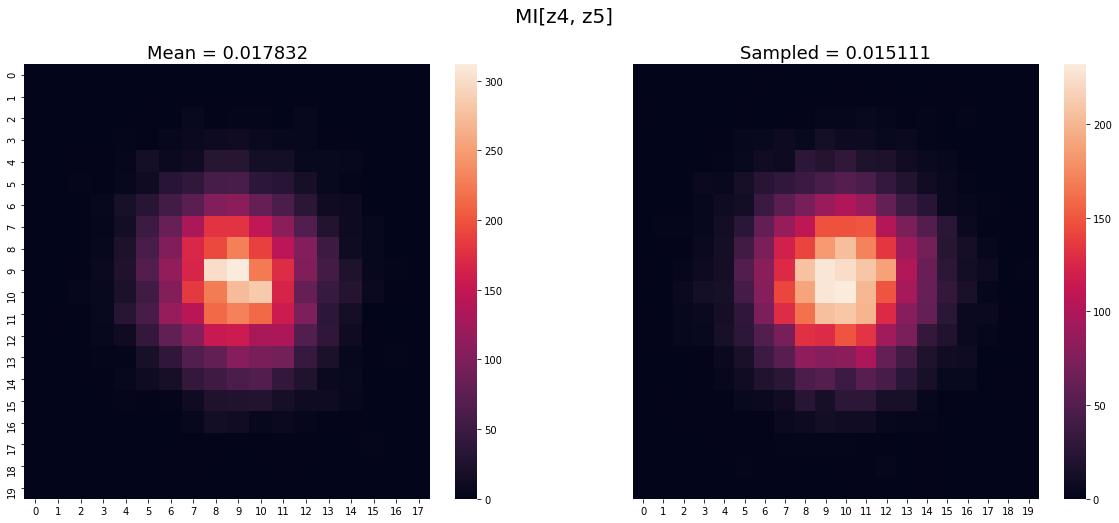

[  0   2   2   6  11  13  30  53  96  94 111  66  46  26  20   7   1   2
   0   0]


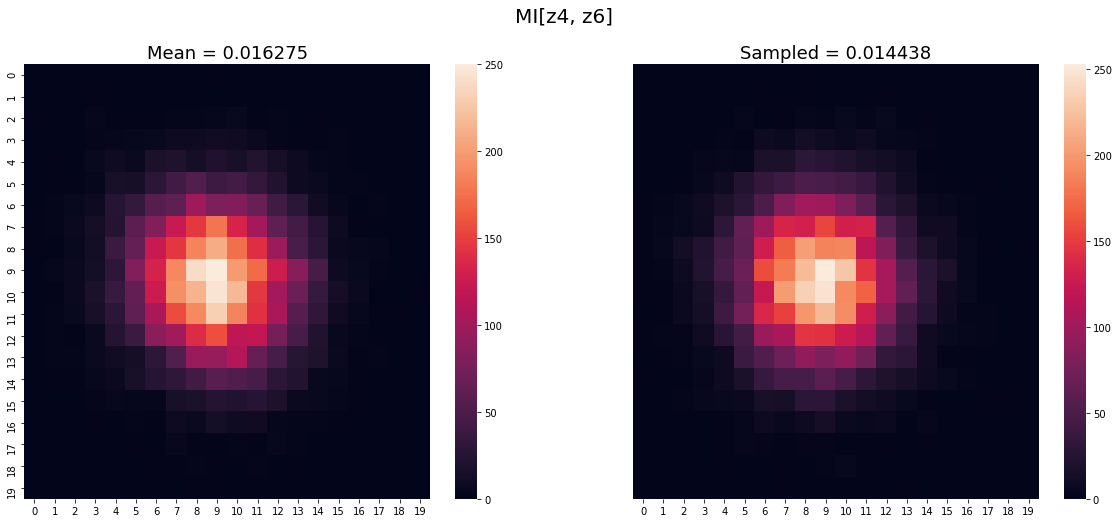

[ 0  2  0  5  7 13 31 39 77 79 82 77 87 44 29 10  2  2  0  0]


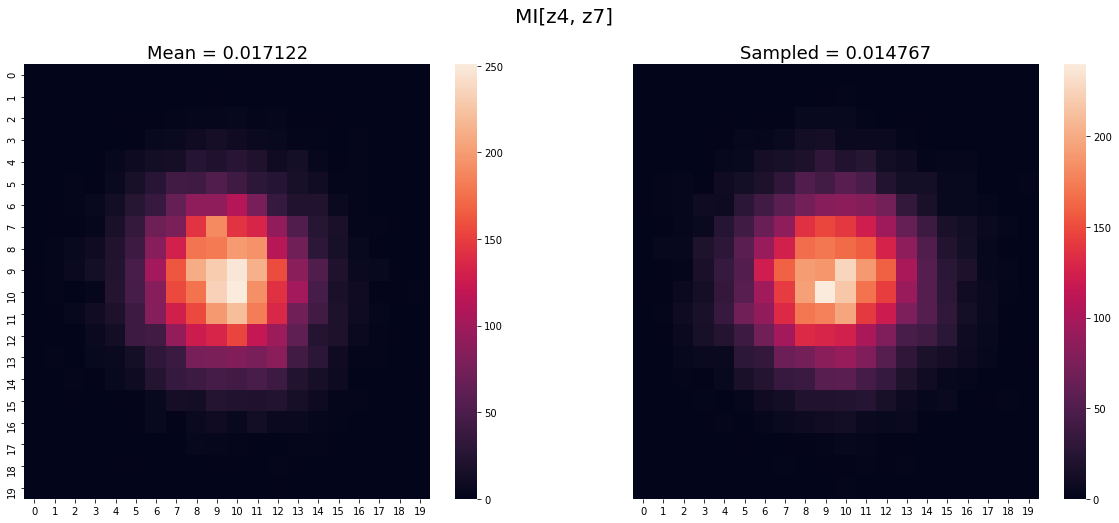

[ 0  0  0  4  3 21 22 49 56 77 89 83 58 52 41 17 13  1  0  0]


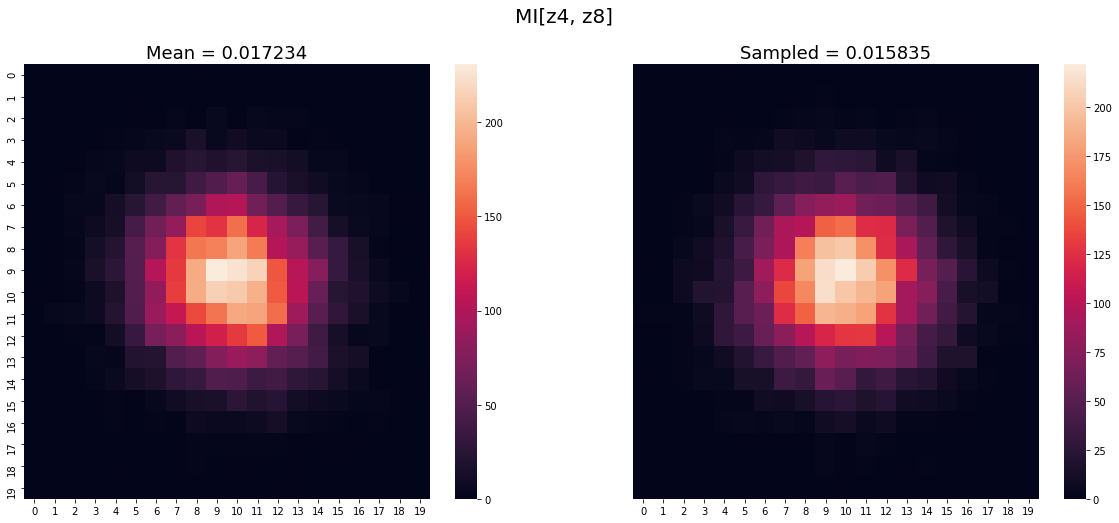

[ 0  0  2  5 12 21 28 51 75 80 83 81 56 41 32 12  5  2  0  0]


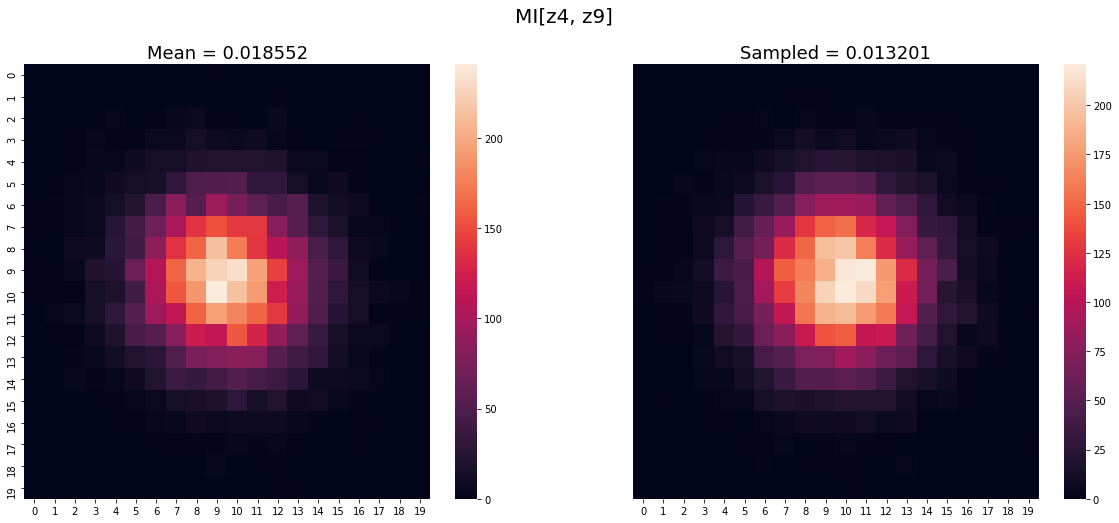

[ 0  0  0  0  1  2  4  8 12 38 58 60 57 41 32  8  9  3  0  0]


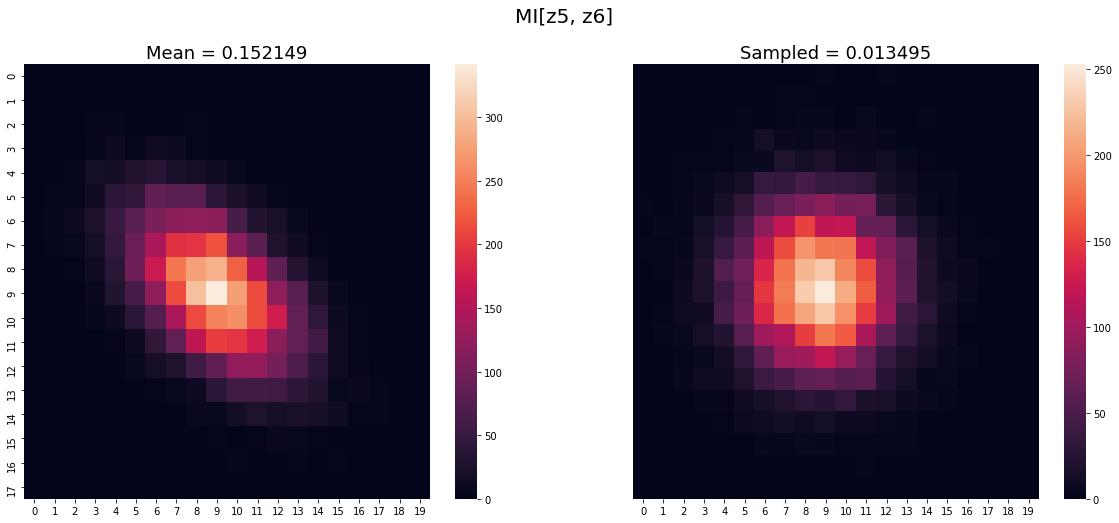

[ 0  0  0  0  0  0  2  6 16 27 32 61 54 59 37 26 11  2  0  0]


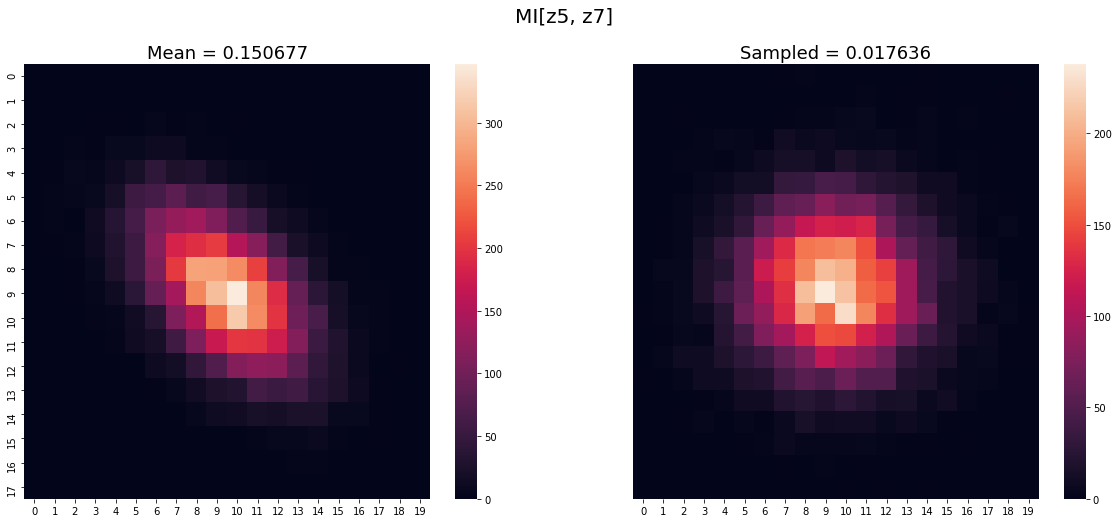

[ 0  0  0  0  0  0  3  3 11 15 32 57 69 57 34 29 15  5  1  2]


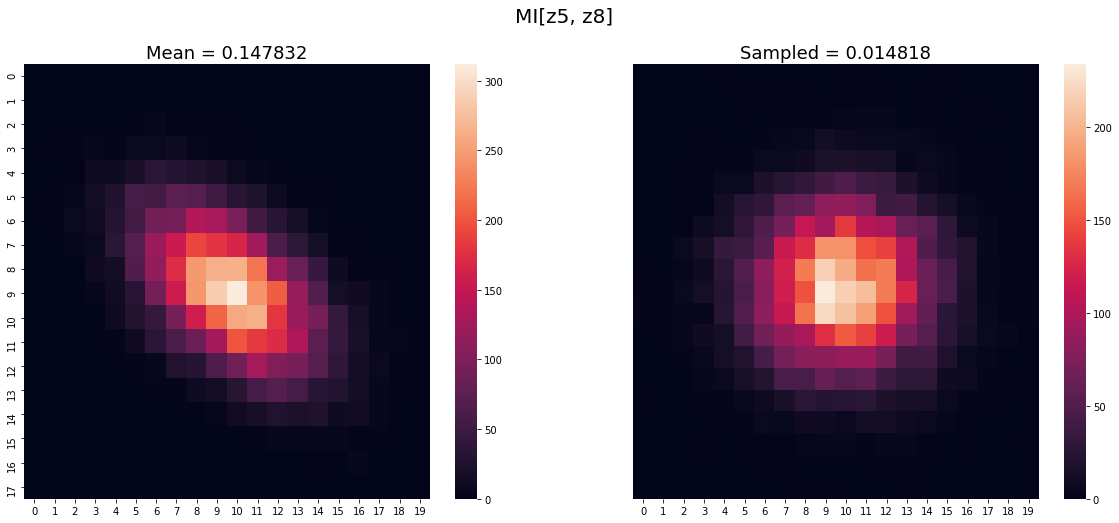

[ 0  0  0  0  0  2  2  4 17 26 43 55 44 54 41 30  9  2  4  0]


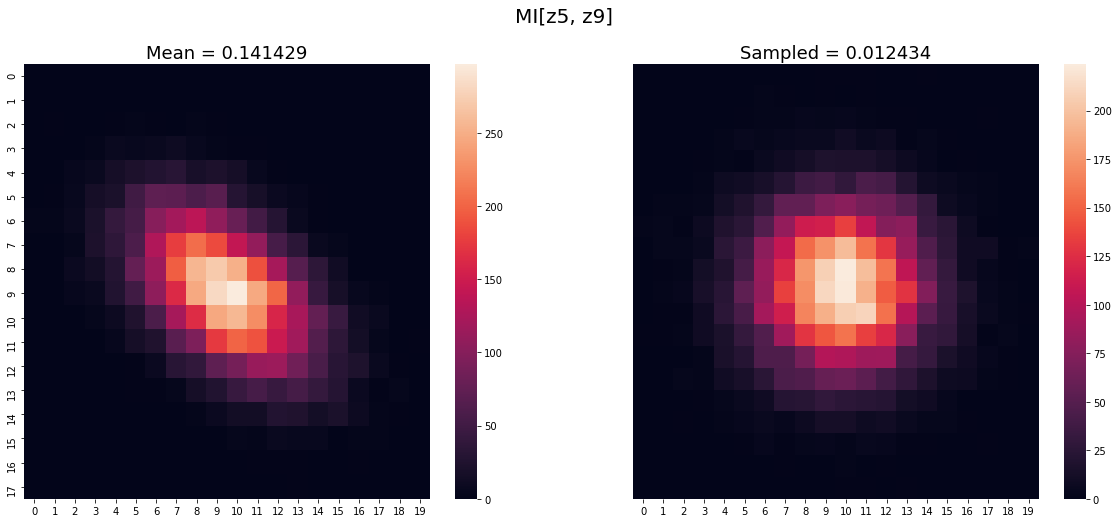

[ 0  0  0  0  0  0  9  7 30 52 58 75 91 70 33 18  7  2  2  0]


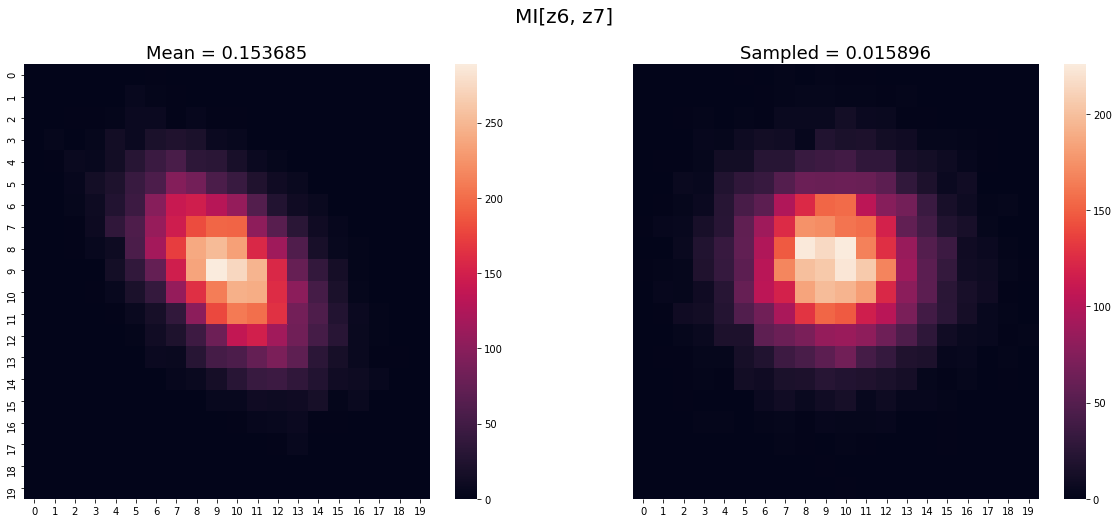

[ 0  0  0  0  1  1  2 15 17 41 61 87 62 49 57 32 18 10  0  1]


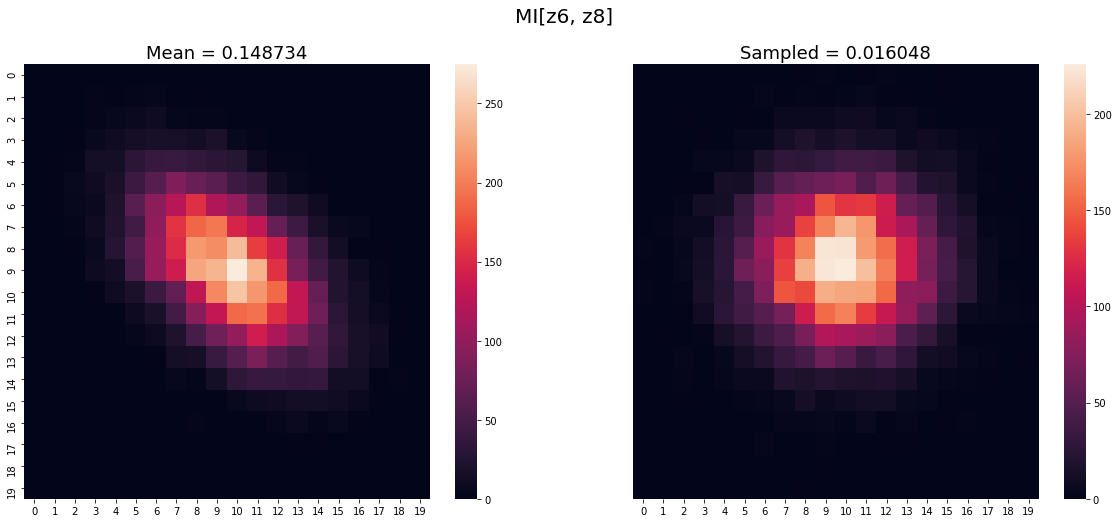

[ 0  0  0  0  0  1  5 15 27 49 53 73 70 67 45 24 17  4  2  2]


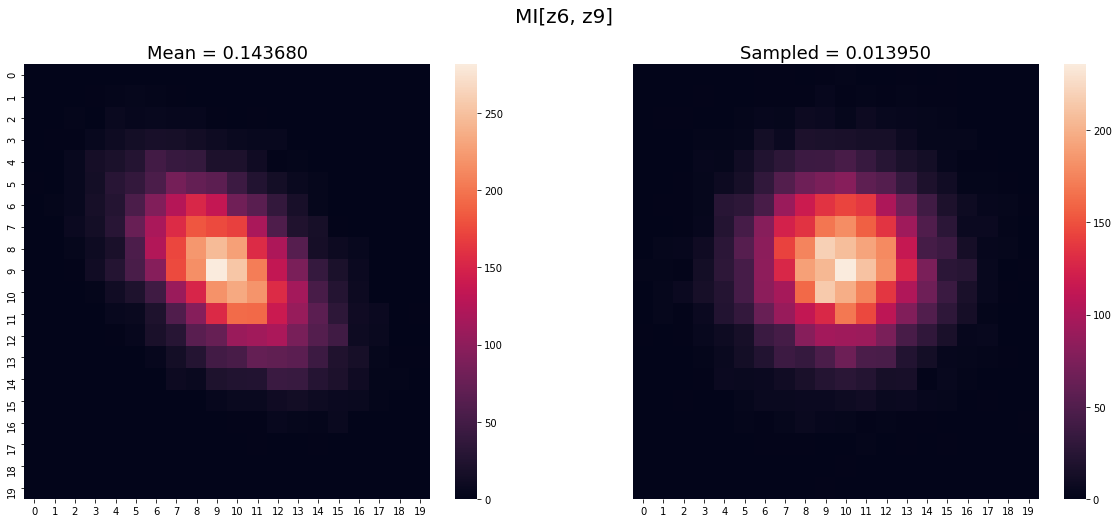

[  0   0   0   0   2   5  12  14  34  47  67  99 104  88  60  34  16   7
   2   0]


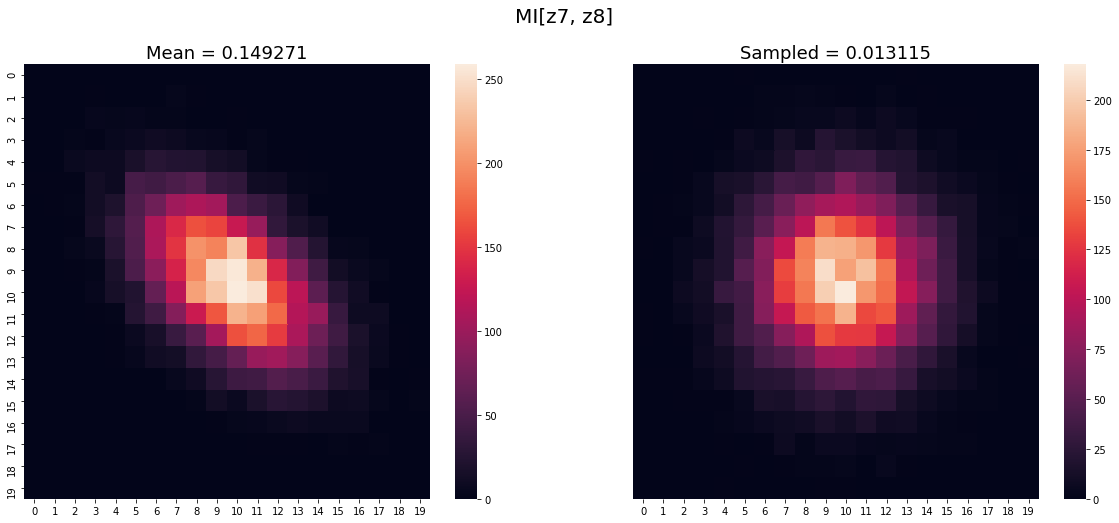

[  0   0   0   0   0   2   3  20  38  64  84 101 102  69  54  31  17   4
   1   1]


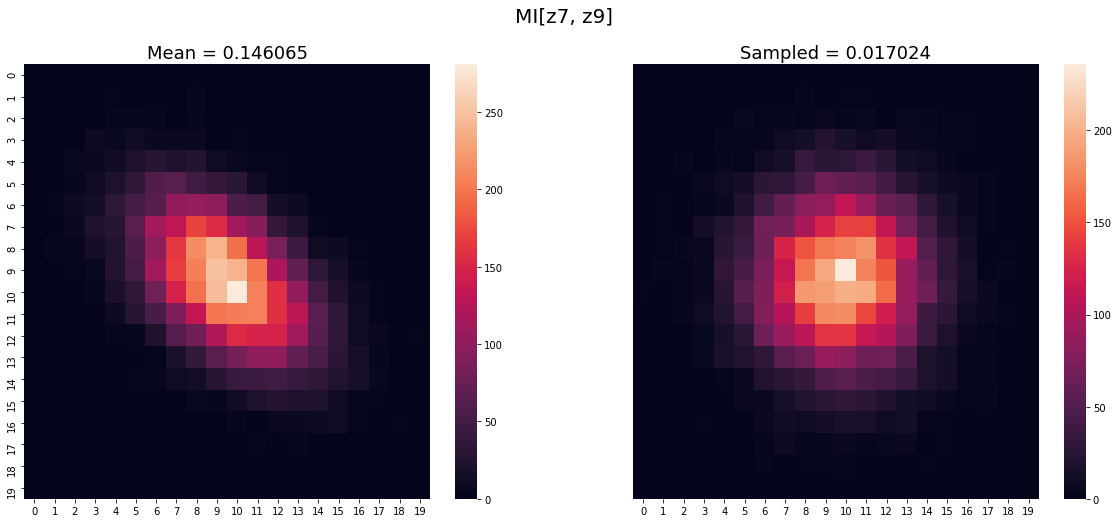

[  0   0   0   0   0   4  13  31  55  71 112 102  91 107  58  34  11   5
   1   1]


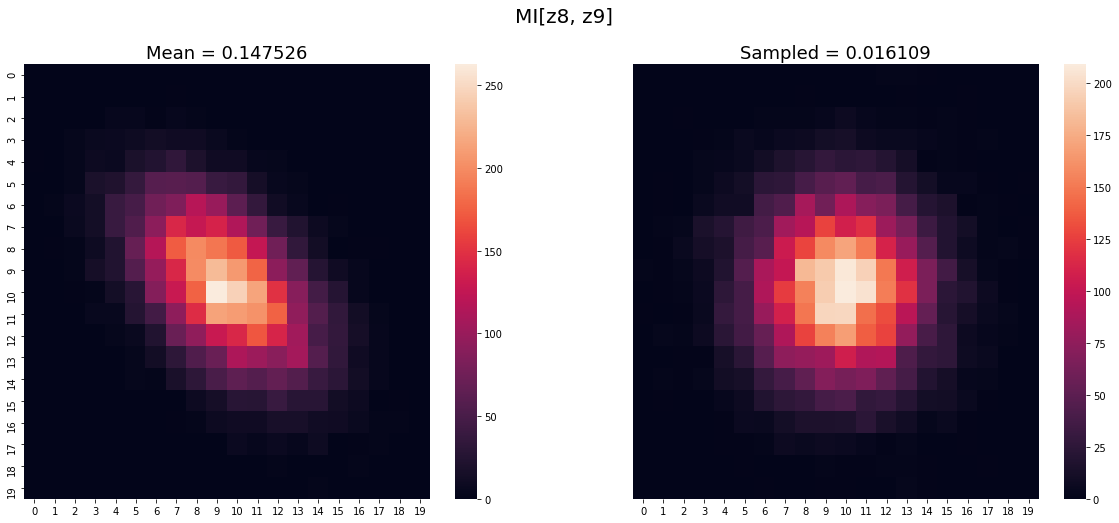

In [67]:
for i in range(factors):
    for j in range(factors):
        if j <= i:
            continue
        cm = contingency_matrix(mean_d[i], mean_d[j])
        print(cm[13])
        cm2 = contingency_matrix(sampled_d[i], sampled_d[j])
        mi_scores = {"MI[z{}, z{}]".format(i, j): 
                     [mutual_info_score(mean_d[i], mean_d[j]), mutual_info_score(sampled_d[i], sampled_d[j])]}
        draw_heatmaps(cm, cm2, mi_scores)
        plt.show()